## Summary

This code was written to verify prediction from https://doi.org/10.1103/PhysRevLett.121.095001, about whether we could observe the Biermann Battery effect in turbulent reconnection events in the magnetosheath.

But First, do we understand how Maxwell equations are verified in MMS?

Coder: Clément Moissard, LPP, 3 Mars 2020

The inputs are:

-) day, hour

-) data_path (where are the data located on computer)

-) filenames    => array of labels containing the names of the four txt files obtained with the MMSData_to_txt prog

-) list_names   => array of labels containing the names of the quantities required for the analysis ('x', 'vix', ...)

-) settings     => array of numbers for the smoothing/filtering procedure; the settings array have to be:
                    -) 2 numbers (1 float and 1 integer) for filtering (cut frequency and Belmont's window order) or
                    -) 1 number (1 integer) for smoothing (length of the Gaussian Kernel in units of number of points)
                    
-) Ref_normal   => array composed by the three GSE components of the global normal direction the local MDD directions                    have to be oriented to (correction procedure). If Ref_normal = [], the Shue model is automatically                    called in order to compute it.

NB: the "ShiMachinery" module saves automatically a txt file containing the result of the computation.   

NB: once all the following cells are evaluated, you have got two series of variables:
   1) the Xn variables where X is whatever you put inside "list_names" and n={1,2,3,4}
   2) the Xnfr where Xn means the same as before and "fr" means "filtered" in some way (smoothed or literally               filtered)           

## Data Gathering

In [1]:
#_inputs cell
import os

#day = '20151030'
#hour = '051500_120'

# '''Burch 2016 event 1'''
# day = '20151016'
# hour = '130530_60'

# '''Burch 2016 event 2'''
# day = '20151016'
# hour = '130630_60'

'''Burch 2016 around the events'''
day  = '20151016'
hour = '130504_159'

data_path = os.environ["MMSDATA"]
wheredataare = data_path + '/' + day + '_' + hour
filenames = ['mms1_GSE_%s_%s.txt' %(day, hour), 'mms2_GSE_%s_%s.txt' %(day, hour),
             'mms3_GSE_%s_%s.txt' %(day, hour), 'mms4_GSE_%s_%s.txt' %(day, hour)]

list_names = ['x', 'y', 'z', 'bx', 'by', 'bz', 
              'ni', 'vix', 'viy', 'viz', 'ne', 'vex', 'vey', 'vez', 
              'Tixx', 'Tiyy', 'Tizz', 'Tixy', 'Tixz', 'Tiyz', 
              'Texx', 'Teyy', 'Tezz', 'Texy', 'Texz', 'Teyz', 
              'Ex', 'Ey', 'Ez', 'Jx', 'Jy', 'Jz']

# Units :  time(s)  x(km)  y(km)  z(km)  bx(nT)  by(nT)  bz(nT),
#          ni(cm^-3)  vix(m/s)  viy(m/s)  viz(m/s)  ne(cm^-3)  vex(m/s)  vey(m/s)  vez(m/s),
#          Tixx(eV)  Tiyy(eV)  Tizz(eV)  Tixy(eV)  Tixz(eV)  Tiyz(eV),
#          Texx(eV)  Teyy(eV)  Tezz(eV)  Texy(eV)  Texz(eV)  Teyz(eV),
#          Ex(mV/m)  Ey(mV/m)  Ez(mV/m)  Jx(A/m^2)  Jy(A/m^2)  Jz(A/m^2) 

# Essayer avec données brutes
# Vérifier les résolutions des champs. Vérifier qu'on interpole jamais un champ
# de haute résolution sur un champ de basse résolution (aliasing)
settings = [3,1]

Ref_normal = []

In [2]:
#_evaluations cell

import matplotlib
matplotlib.use('nbagg') #_comment this line if you don't need to interact with plots (zoom, translations, savings...)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' #_please, comment this line if your are not a Mac user
from RMs_module_collection import *
from CMs_module_collection import *

#_building for the xlabel used in plots and in the "ShiMachinery" module
x_label = 'time [s] since ' + ' '.join(filenames[0].split('_')[2:4])

time, MMS_Data_or, MMS_Data_fr = lecture(wheredataare, filenames, list_names, settings)

#_the following lines order the MMS_Data_or, MMS_Data_fr arrays in global variables as explained before
for i,superobj in enumerate(MMS_Data_or):
        for obj,name in zip(superobj,list_names):
            globals()[''.join([name,str(i+1)])] = obj
for i,superobj in enumerate(MMS_Data_fr):
        for obj,name in zip(superobj,list_names):
            globals()[''.join([name,str(i+1),'fr'])] = obj


/home/clement/Desktop/MMS_Gradients/RMs_module_collection.py:39: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)        #....1,3,1      matches
/home/clement/Desktop/MMS_Gradients/RMs_module_collection.py:477: RuntimeWarning: divide by zero encountered in double_scalars
  dewindow = np.array([1/obj  for obj in window])


In [3]:
coord = [x1*1e3,y1*1e3,z1*1e3,x2*1e3,y2*1e3,z2*1e3,x3*1e3,y3*1e3,z3*1e3,x4*1e3,y4*1e3,z4*1e3]
kvec = ReciprocalVectors(coord)

Some physical constants for conversion to USI

In [4]:
kB = 1.380649e-23
qe = 1.6021766208e-19
µ_0 = 4*np.pi*10**-7
T_K_by_eV = qe / kB
N_SI_by_cc = 1e6

### Definitions and renaming of raw Data

In [5]:
#### Definitions and renaming of raw Data

Te_sat1 = (Texx1fr + Teyy1fr + Tezz1fr) / 3 * T_K_by_eV #[K]
Te_sat2 = (Texx2fr + Teyy2fr + Tezz2fr) / 3 * T_K_by_eV
Te_sat3 = (Texx3fr + Teyy3fr + Tezz3fr) / 3 * T_K_by_eV
Te_sat4 = (Texx4fr + Teyy4fr + Tezz4fr) / 3 * T_K_by_eV
Te_sats = [Te_sat1, Te_sat2, Te_sat3, Te_sat4]    

Te = (Te_sat1 + Te_sat2 + Te_sat3 + Te_sat4) / 4
Te0 = np.mean(Te)

Ne_sat1 = ne1fr * N_SI_by_cc #[nb.m^-3]
Ne_sat2 = ne2fr * N_SI_by_cc
Ne_sat3 = ne3fr * N_SI_by_cc
Ne_sat4 = ne4fr * N_SI_by_cc
Ne_sats = [Ne_sat1, Ne_sat2, Ne_sat3, Ne_sat4] 

Ne = (Ne_sat1 + Ne_sat2 + Ne_sat3 + Ne_sat4) / 4
Ne0 = np.mean(Ne)

# Magnetic Field in (T)

Bx_sat1 = bx1fr * 1e-9
Bx_sat2 = bx2fr * 1e-9
Bx_sat3 = bx3fr * 1e-9
Bx_sat4 = bx4fr * 1e-9
Bx_sats = [Bx_sat1, Bx_sat2, Bx_sat3, Bx_sat4]
Bx = (Bx_sat1 + Bx_sat2 + Bx_sat3 + Bx_sat4) / 4

By_sat1 = by1fr * 1e-9
By_sat2 = by2fr * 1e-9
By_sat3 = by3fr * 1e-9
By_sat4 = by4fr * 1e-9
By_sats = [By_sat1, By_sat2, By_sat3, By_sat4] 
By = (By_sat1 + By_sat2 + By_sat3 + By_sat4) / 4

Bz_sat1 = bz1fr * 1e-9
Bz_sat2 = bz2fr * 1e-9
Bz_sat3 = bz3fr * 1e-9
Bz_sat4 = bz4fr * 1e-9
Bz_sats = [Bz_sat1, Bz_sat2, Bz_sat3, Bz_sat4] 
Bz = (Bz_sat1 + Bz_sat2 + Bz_sat3 + Bz_sat4) / 4

# Electric Field in (V/m^3)
Ex_sat1 = Ex1fr * 1e-3
Ex_sat2 = Ex2fr * 1e-3
Ex_sat3 = Ex3fr * 1e-3
Ex_sat4 = Ex4fr * 1e-3
Ex_sats = [Ex_sat1, Ex_sat2, Ex_sat3, Ex_sat4]
Ex = (Ex_sat1 + Ex_sat2 + Ex_sat3 + Ex_sat4) / 4

Ey_sat1 = Ey1fr * 1e-3
Ey_sat2 = Ey2fr * 1e-3
Ey_sat3 = Ey3fr * 1e-3
Ey_sat4 = Ey4fr * 1e-3
Ey_sats = [Ey_sat1, Ey_sat2, Ey_sat3, Ey_sat4] 
Ey = (Ey_sat1 + Ey_sat2 + Ey_sat3 + Ey_sat4) / 4

Ez_sat1 = Ez1fr * 1e-3
Ez_sat2 = Ez2fr * 1e-3
Ez_sat3 = Ez3fr * 1e-3
Ez_sat4 = Ez4fr * 1e-3
Ez_sats = [Ez_sat1, Ez_sat2, Ez_sat3, Ez_sat4] 
Ez = (Ez_sat1 + Ez_sat2 + Ez_sat3 + Ez_sat4) / 4

# electron velocity in (m/s)
vex_sat1 = vex1fr
vex_sat2 = vex2fr 
vex_sat3 = vex3fr 
vex_sat4 = vex4fr 
vex_sats = [vex_sat1, vex_sat2, vex_sat3, vex_sat4]
vex = (vex_sat1 + vex_sat2 + vex_sat3 + vex_sat4) / 4

vey_sat1 = vey1fr 
vey_sat2 = vey2fr 
vey_sat3 = vey3fr 
vey_sat4 = vey4fr 
vey_sats = [vey_sat1, vey_sat2, vey_sat3, vey_sat4] 
vey = (vey_sat1 + vey_sat2 + vey_sat3 + vey_sat4) / 4

vez_sat1 = vez1fr 
vez_sat2 = vez2fr 
vez_sat3 = vez3fr 
vez_sat4 = vez4fr 
vez_sats = [vez_sat1, vez_sat2, vez_sat3, vez_sat4] 
vez = (vez_sat1 + vez_sat2 + vez_sat3 + vez_sat4) / 4

ve = [vex, vey, vez]


# ion velocity in (m/s)
vix_sat1 = vix1fr
vix_sat2 = vix2fr 
vix_sat3 = vix3fr 
vix_sat4 = vix4fr 
vix_sats = [vix_sat1, vix_sat2, vix_sat3, vix_sat4]
vix = (vix_sat1 + vix_sat2 + vix_sat3 + vix_sat4) / 4

viy_sat1 = viy1fr 
viy_sat2 = viy2fr 
viy_sat3 = viy3fr 
viy_sat4 = viy4fr 
viy_sats = [viy_sat1, viy_sat2, viy_sat3, viy_sat4] 
viy = (viy_sat1 + viy_sat2 + viy_sat3 + viy_sat4) / 4

viz_sat1 = viz1fr 
viz_sat2 = viz2fr 
viz_sat3 = viz3fr 
viz_sat4 = viz4fr 
viz_sats = [viz_sat1, viz_sat2, viz_sat3, viz_sat4] 
viz = (viz_sat1 + viz_sat2 + viz_sat3 + viz_sat4) / 4

vi = [vix, viy, viz]

# Current in (A/m^2)
jx_sat1 = Jx1fr 
jx_sat2 = Jx2fr 
jx_sat3 = Jx3fr 
jx_sat4 = Jx4fr 
jx_sats = [jx_sat1, jx_sat2, jx_sat3, jx_sat4]
jx = (jx_sat1 + jx_sat2 + jx_sat3 + jx_sat4) / 4

jy_sat1 = Jy1fr 
jy_sat2 = Jy2fr 
jy_sat3 = Jy3fr 
jy_sat4 = Jy4fr 
jy_sats = [jy_sat1, jy_sat2, jy_sat3, jy_sat4] 
jy = (jy_sat1 + jy_sat2 + jy_sat3 + jy_sat4) / 4

jz_sat1 = Jz1fr 
jz_sat2 = Jz2fr 
jz_sat3 = Jz3fr 
jz_sat4 = Jz4fr 
jz_sats = [jz_sat1, jz_sat2, jz_sat3, jz_sat4] 
jz = (jz_sat1 + jz_sat2 + jz_sat3 + jz_sat4) / 4

# Pressure Tensor in (Pa)
Pexx_sat1 = Ne_sat1*kB*Texx1fr * T_K_by_eV
Pexy_sat1 = Ne_sat1*kB*Texy1fr * T_K_by_eV
Pexz_sat1 = Ne_sat1*kB*Texz1fr * T_K_by_eV
Peyy_sat1 = Ne_sat1*kB*Teyy1fr * T_K_by_eV
Peyz_sat1 = Ne_sat1*kB*Teyz1fr * T_K_by_eV
Pezz_sat1 = Ne_sat1*kB*Tezz1fr * T_K_by_eV

Pexx_sat2 = Ne_sat2*kB*Texx2fr * T_K_by_eV
Pexy_sat2 = Ne_sat2*kB*Texy2fr * T_K_by_eV
Pexz_sat2 = Ne_sat2*kB*Texz2fr * T_K_by_eV
Peyy_sat2 = Ne_sat2*kB*Teyy2fr * T_K_by_eV
Peyz_sat2 = Ne_sat2*kB*Teyz2fr * T_K_by_eV
Pezz_sat2 = Ne_sat2*kB*Tezz2fr * T_K_by_eV

Pexx_sat3 = Ne_sat3*kB*Texx3fr * T_K_by_eV
Pexy_sat3 = Ne_sat3*kB*Texy3fr * T_K_by_eV
Pexz_sat3 = Ne_sat3*kB*Texz3fr * T_K_by_eV
Peyy_sat3 = Ne_sat3*kB*Teyy3fr * T_K_by_eV
Peyz_sat3 = Ne_sat3*kB*Teyz3fr * T_K_by_eV
Pezz_sat3 = Ne_sat3*kB*Tezz3fr * T_K_by_eV

Pexx_sat4 = Ne_sat4*kB*Texx4fr * T_K_by_eV
Pexy_sat4 = Ne_sat4*kB*Texy4fr * T_K_by_eV
Pexz_sat4 = Ne_sat4*kB*Texz4fr * T_K_by_eV
Peyy_sat4 = Ne_sat4*kB*Teyy4fr * T_K_by_eV
Peyz_sat4 = Ne_sat4*kB*Teyz4fr * T_K_by_eV
Pezz_sat4 = Ne_sat4*kB*Tezz4fr * T_K_by_eV

Pe = [
    [Pexx_sat1,Peyy_sat1,Pezz_sat1,Pexy_sat1,Pexz_sat1,Peyz_sat1],
    [Pexx_sat2,Peyy_sat2,Pezz_sat2,Pexy_sat2,Pexz_sat2,Peyz_sat2],
    [Pexx_sat3,Peyy_sat3,Pezz_sat3,Pexy_sat3,Pexz_sat3,Peyz_sat3],
    [Pexx_sat4,Peyy_sat4,Pezz_sat4,Pexy_sat4,Pexz_sat4,Peyz_sat4]
     ]

B = [Bx_sat1, By_sat1, Bz_sat1, Bx_sat2, By_sat2, Bz_sat2, Bx_sat3, By_sat3, Bz_sat3, Bx_sat4, By_sat4, Bz_sat4]
E = [Ex_sat1, Ey_sat1, Ez_sat1, Ex_sat2, Ey_sat2, Ez_sat2, Ex_sat3, Ey_sat3, Ez_sat3, Ex_sat4, Ey_sat4, Ez_sat4]

x = (x1fr+x2fr+x3fr+x4fr) / 4 * 1e3 #[m]



### Region of focus

In [6]:
time_lims = [112,119]
#time_lims=[time[0], time[-1]]

<IPython.core.display.Javascript object>


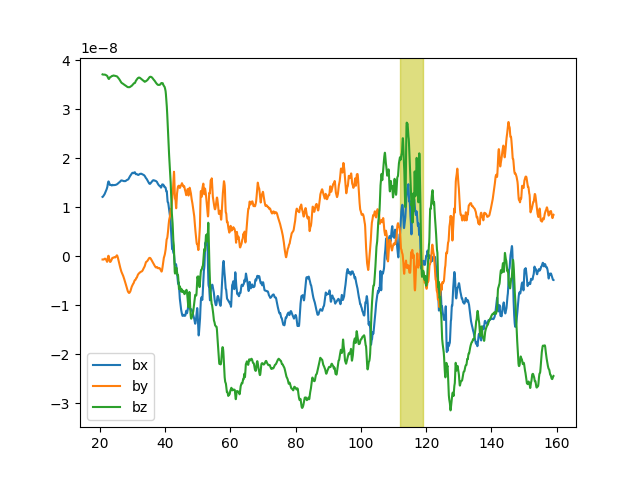

In [7]:
plt.plot(time, Bx, label='bx')
plt.plot(time, By, label='by')
plt.plot(time, Bz, label='bz')
plt.legend()
plt.axvspan(time_lims[0],time_lims[1], 0, np.max(Te/Te0), color='y', alpha=0.5)
plt.show()


## Maxwell Equations

### Maxwell Flux (not great)

$$ \nabla \cdot B = 0 $$

<IPython.core.display.Javascript object>


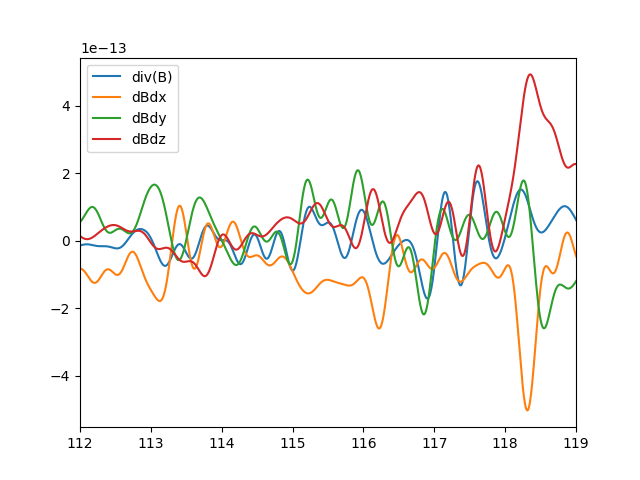

Infinity would be good. Anything under that better be big. 1 would be pretty bad
3.9220983624816146


In [8]:
# Maxwell Flux  (not great)

divB = div(coord, B)


dBdx = dQdx(coord, B)
dBdy = dQdy(coord, B)
dBdz = dQdz(coord, B)


plt.plot(time, divB, label="div(B)")
plt.plot(time, dBdx, label="dBdx")
plt.plot(time, dBdy, label="dBdy")
plt.plot(time, dBdz, label="dBdz")
plt.legend()
plt.xlim(time_lims)
plt.show()

isdivBnull = (1./3 * (np.mean(dBdx**2) + np.mean(dBdy**2) + np.mean(dBdz**2))) / np.mean(divB**2)

print("Infinity would be good. Anything under that better be big. 1 would be pretty bad")
print(isdivBnull)

### Maxwell Ampere (quite decent!)

$$ \nabla \times B = \mu_0 j $$

<IPython.core.display.Javascript object>


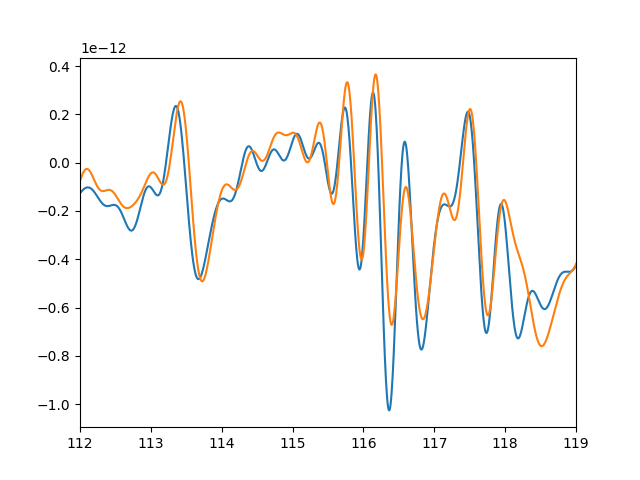

<IPython.core.display.Javascript object>


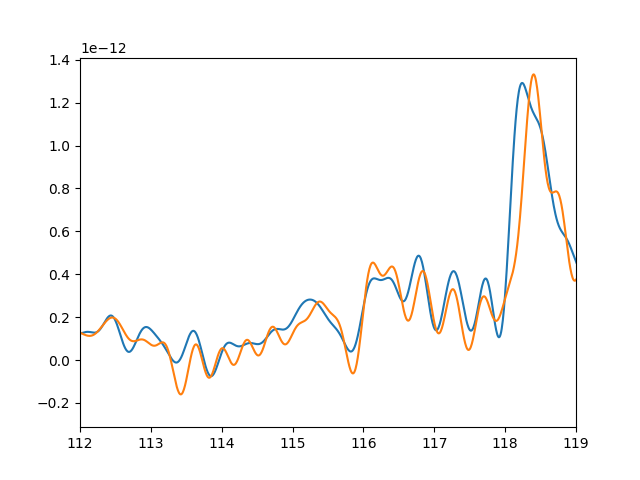

<IPython.core.display.Javascript object>


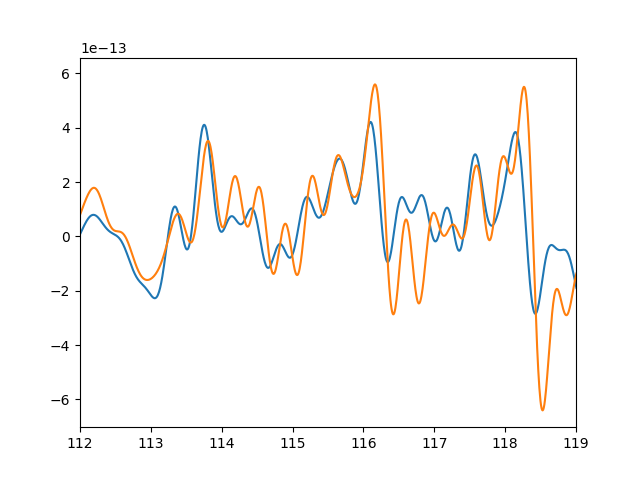

In [9]:
# Maxwell Ampere (quite decent!)

curlB = curl(coord, B)

plt.plot(time, µ_0 * jx)
plt.plot(time, curlB[0])
plt.xlim(time_lims)
plt.show()


plt.plot(time, µ_0 * jy)
plt.plot(time, curlB[1])
plt.xlim(time_lims)
plt.show()

plt.plot(time, µ_0 * jz)
plt.plot(time, curlB[2])
plt.xlim(time_lims)
plt.show()

### Maxwell Faraday (really bad!)

$$\nabla \times E = - \partial B / \partial t$$

#### Computation of $\partial B / \partial t$

In [10]:
te, tlen = (time[-1]-time[0])/(len(time)), len(time)

dBxdt = np.gradient(Bx,te)
dBydt = np.gradient(By,te)
dBzdt = np.gradient(Bz,te)

dBdt = [dBxdt, dBydt, dBzdt]

# Problème de signe !
vegradB = -convection(ve, coord, B)
vigradB = -convection(vi, coord, B)

<IPython.core.display.Javascript object>


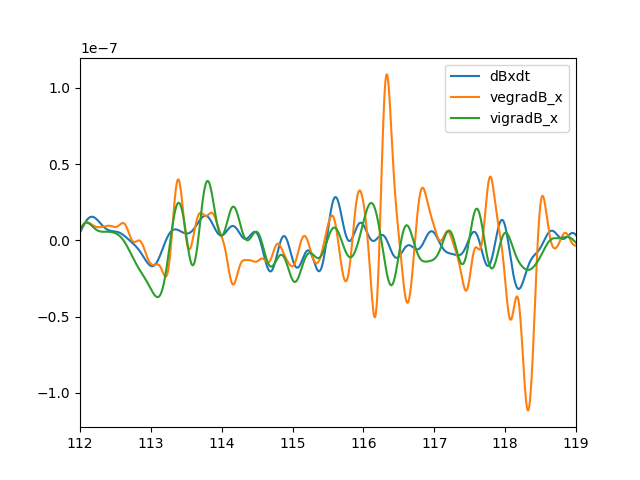

<IPython.core.display.Javascript object>


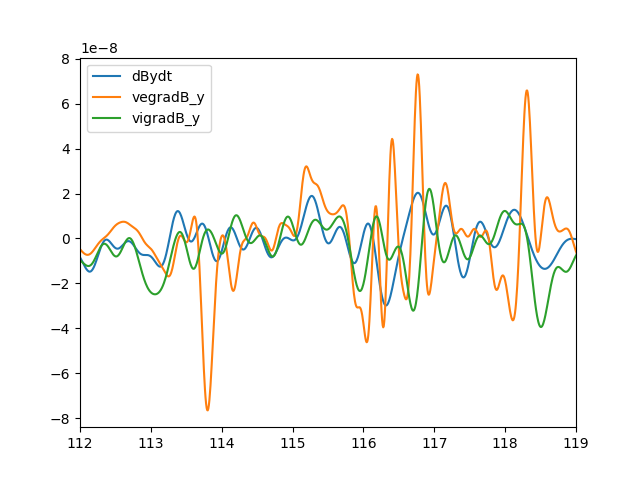

<IPython.core.display.Javascript object>


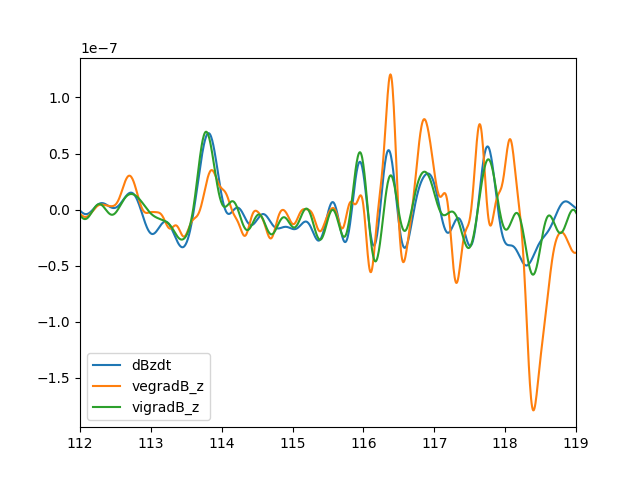

In [11]:
plt.plot(time, dBxdt, label='dBxdt')
plt.plot(time, vegradB[0], label='vegradB_x')
plt.plot(time, vigradB[0], label='vigradB_x')
plt.xlim(time_lims)
plt.legend()
plt.show()

plt.plot(time, dBydt, label='dBydt')
plt.plot(time, vegradB[1], label='vegradB_y')
plt.plot(time, vigradB[1], label='vigradB_y')
plt.xlim(time_lims)
plt.legend()
plt.show()

plt.plot(time, dBzdt, label='dBzdt')
plt.plot(time, vegradB[2], label='vegradB_z')
plt.plot(time, vigradB[2], label='vigradB_z')
plt.legend()
plt.xlim(time_lims)
plt.show()

In [12]:
# Conclusion:

δBδt = dBdt - vigradB

#### Maxwell Faraday

<IPython.core.display.Javascript object>


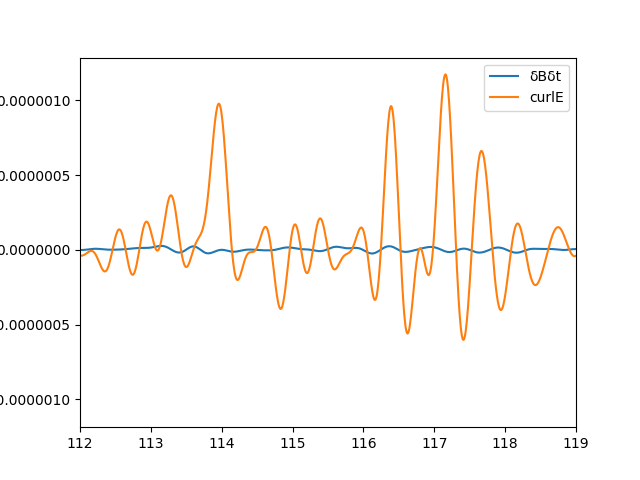

<IPython.core.display.Javascript object>


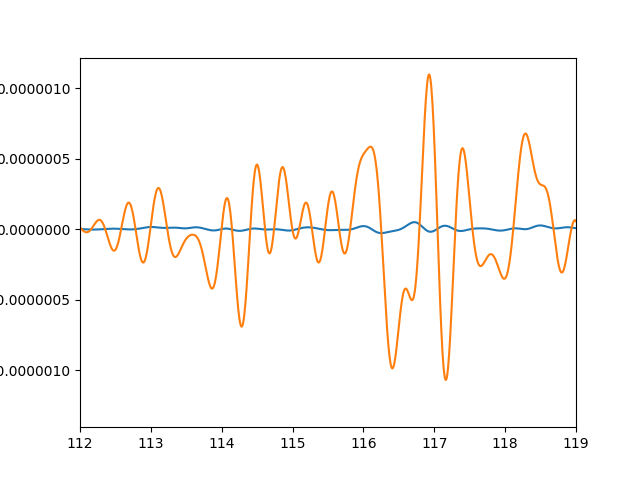

<IPython.core.display.Javascript object>


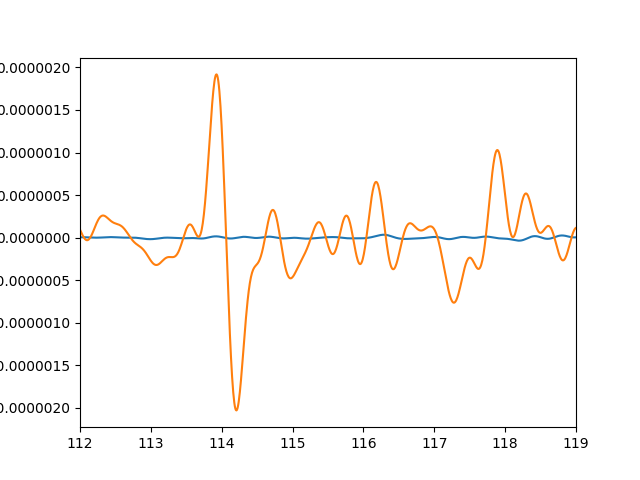

In [13]:
# Maxwell Faraday  (really bad!)

curlE = curl(coord, E)


plt.plot(time, δBδt[0], label='δBδt')
plt.plot(time, curlE[0], label='curlE')
plt.xlim(time_lims)
plt.legend()
plt.show()

plt.plot(time, δBδt[1], label='δBδt')
plt.plot(time, curlE[1], label='curlE')
plt.xlim(time_lims)
plt.show()

plt.plot(time, δBδt[2])
plt.plot(time, curlE[2])
plt.xlim(time_lims)
plt.show()

## Ohm's law

### Preparatory computations

$$v_i \times B$$

In [14]:
v_cross_B_1 = vector_product(vix_sat1,viy_sat1,viz_sat1,Bx_sat1,By_sat1,Bz_sat1)
v_cross_B_2 = vector_product(vix_sat2,viy_sat2,viz_sat2,Bx_sat2,By_sat2,Bz_sat2)
v_cross_B_3 = vector_product(vix_sat3,viy_sat3,viz_sat3,Bx_sat3,By_sat3,Bz_sat3)
v_cross_B_4 = vector_product(vix_sat4,viy_sat4,viz_sat4,Bx_sat4,By_sat4,Bz_sat4)
v_cross_B_x = (v_cross_B_1[0] + v_cross_B_2[0] + v_cross_B_3[0] + v_cross_B_4[0]) / 4
v_cross_B_y = (v_cross_B_1[1] + v_cross_B_2[1] + v_cross_B_3[1] + v_cross_B_4[1]) / 4
v_cross_B_z = (v_cross_B_1[2] + v_cross_B_2[2] + v_cross_B_3[2] + v_cross_B_4[2]) / 4
print(np.sqrt(np.mean(v_cross_B_x**2 + v_cross_B_y**2 + v_cross_B_z**2)))

0.003551112722712918


$$\frac{j \times B}{n_e q_e}$$

In [15]:
j_cross_B_1 = vector_product(jx_sat1,jy_sat1,jz_sat1,Bx_sat1,By_sat1,Bz_sat1) / (qe*Ne_sat1)
j_cross_B_2 = vector_product(jx_sat2,jy_sat2,jz_sat2,Bx_sat2,By_sat2,Bz_sat2) / (qe*Ne_sat2)
j_cross_B_3 = vector_product(jx_sat3,jy_sat3,jz_sat3,Bx_sat3,By_sat3,Bz_sat3) / (qe*Ne_sat3)
j_cross_B_4 = vector_product(jx_sat4,jy_sat4,jz_sat4,Bx_sat4,By_sat4,Bz_sat4) / (qe*Ne_sat4)
j_cross_B_x = (j_cross_B_1[0] + j_cross_B_2[0] + j_cross_B_3[0] + j_cross_B_4[0]) / 4
j_cross_B_y = (j_cross_B_1[1] + j_cross_B_2[1] + j_cross_B_3[1] + j_cross_B_4[1]) / 4 
j_cross_B_z = (j_cross_B_1[2] + j_cross_B_2[2] + j_cross_B_3[2] + j_cross_B_4[2]) / 4
print(np.sqrt(np.mean(j_cross_B_x**2 + j_cross_B_y**2 + j_cross_B_z**2)))

0.00264319031634546


$$v_e \times B$$

In [16]:
ve_cross_B_1 = vector_product(vex1fr,vey1fr,vez1fr,Bx_sat1,By_sat1,Bz_sat1)
ve_cross_B_2 = vector_product(vex2fr,vey2fr,vez2fr,Bx_sat2,By_sat2,Bz_sat2)
ve_cross_B_3 = vector_product(vex3fr,vey3fr,vez3fr,Bx_sat3,By_sat3,Bz_sat3)
ve_cross_B_4 = vector_product(vex4fr,vey4fr,vez4fr,Bx_sat4,By_sat4,Bz_sat4)
ve_cross_B_x = (ve_cross_B_1[0] + ve_cross_B_2[0] + ve_cross_B_3[0] + ve_cross_B_4[0]) / 4
ve_cross_B_y = (ve_cross_B_1[1] + ve_cross_B_2[1] + ve_cross_B_3[1] + ve_cross_B_4[1]) / 4
ve_cross_B_z = (ve_cross_B_1[2] + ve_cross_B_2[2] + ve_cross_B_3[2] + ve_cross_B_4[2]) / 4
print(np.sqrt(np.mean(ve_cross_B_x**2)))

0.002500818611358514


$$\frac{\nabla \cdot P_e}{n_e q_e}$$

In [17]:
divPe_x = divPe_Computator(coord, Pe)[:,0] / (qe*Ne)
divPe_y = divPe_Computator(coord, Pe)[:,1] / (qe*Ne)
divPe_z = divPe_Computator(coord, Pe)[:,2] / (qe*Ne)
print(np.sqrt(np.mean(divPe_x**2 + divPe_y**2 + divPe_z**2)))

0.0006217396688278773


### Verification of Ohm's law 1

$$ E = - v_i \times B + \frac{j \times B}{n_e q_e} - \frac{\nabla \cdot P_e}{n_e q_e}$$

<IPython.core.display.Javascript object>


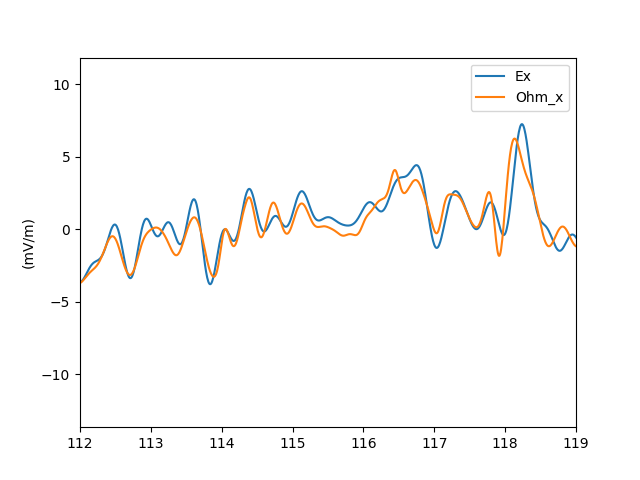

<IPython.core.display.Javascript object>


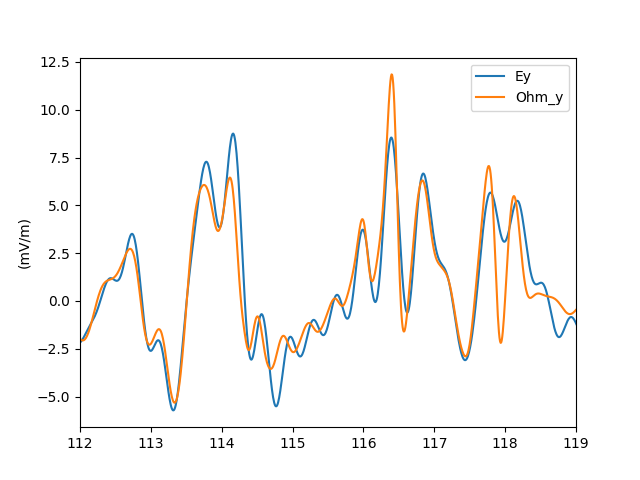

<IPython.core.display.Javascript object>


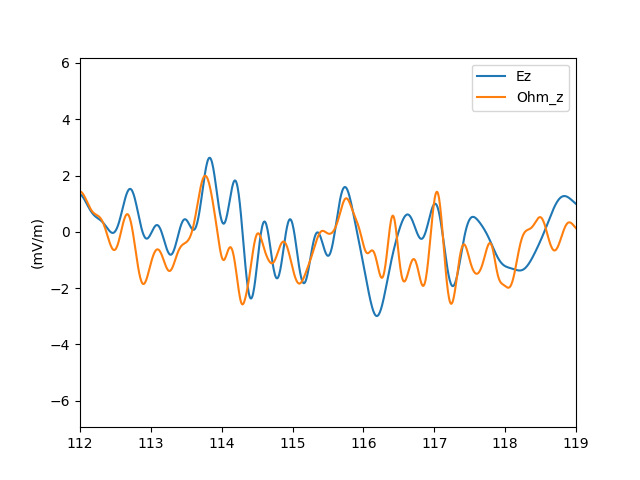

<IPython.core.display.Javascript object>


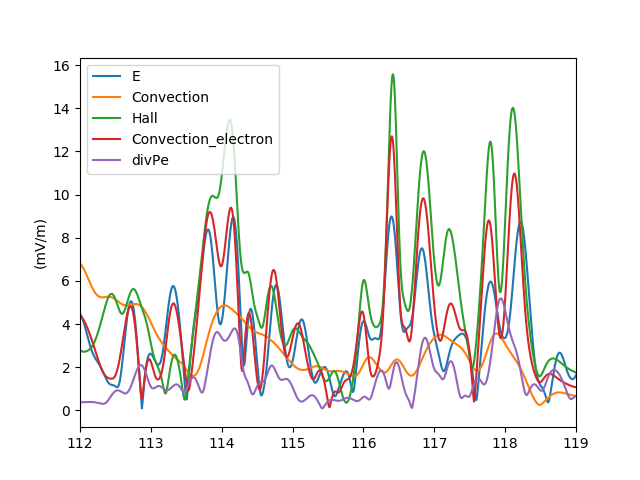

In [18]:
# Plot each term separatly. Allows to know when which physics works or breakdowns.

LHS_x = Ex * 1e3
LHS_y = Ey * 1e3
LHS_z = Ez * 1e3

RHS_x = (- v_cross_B_x + j_cross_B_x - divPe_x) *1e3
RHS_y = (- v_cross_B_y + j_cross_B_y - divPe_y) *1e3
RHS_z = (- v_cross_B_z + j_cross_B_z - divPe_z) *1e3

plt.plot(time, LHS_x, label='Ex')
plt.plot(time, RHS_x, label='Ohm_x')
plt.legend()
plt.xlim(time_lims)
plt.ylabel('(mV/m)')
plt.show()

plt.plot(time, LHS_y, label='Ey')
plt.plot(time, RHS_y, label='Ohm_y')
plt.legend()
plt.xlim(time_lims)
plt.ylabel('(mV/m)')
plt.show()

plt.plot(time, LHS_z, label='Ez')
plt.plot(time, RHS_z, label='Ohm_z')
plt.legend()
plt.xlim(time_lims)
plt.ylabel('(mV/m)')
plt.show()

plt.plot(time, np.sqrt(LHS_x**2 + LHS_y**2 + LHS_z**2), label='E')
plt.plot(time, np.sqrt(v_cross_B_x**2 + v_cross_B_y**2 + v_cross_B_z**2)*1e3, label='Convection')
plt.plot(time, np.sqrt(j_cross_B_x**2 + j_cross_B_y**2 + j_cross_B_z**2)*1e3, label='Hall')
plt.plot(time, np.sqrt(ve_cross_B_x**2 + ve_cross_B_y**2 + ve_cross_B_z**2)*1e3, label='Convection_electron')
plt.plot(time, np.sqrt(divPe_x**2 + divPe_y**2 + divPe_z**2)*1e3, label='divPe')
plt.legend()
plt.xlim(time_lims)
plt.ylabel('(mV/m)')
plt.show()

### Verification of Ohm's law 2: with electron velocity

$$ E = - v_e \times B - \frac{\nabla \cdot P_e}{n_e q_e} $$

<IPython.core.display.Javascript object>


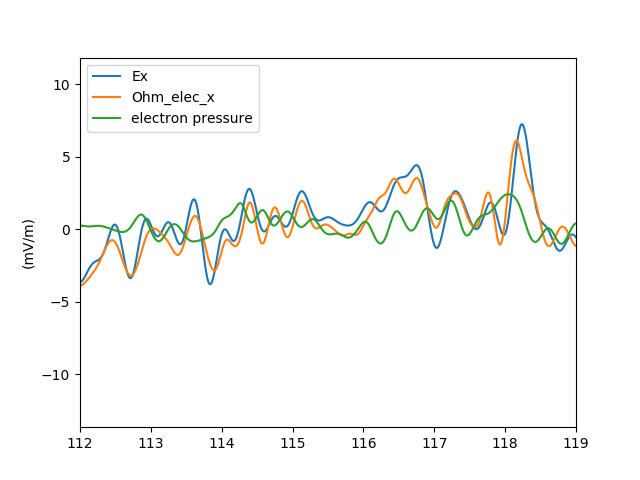

<IPython.core.display.Javascript object>


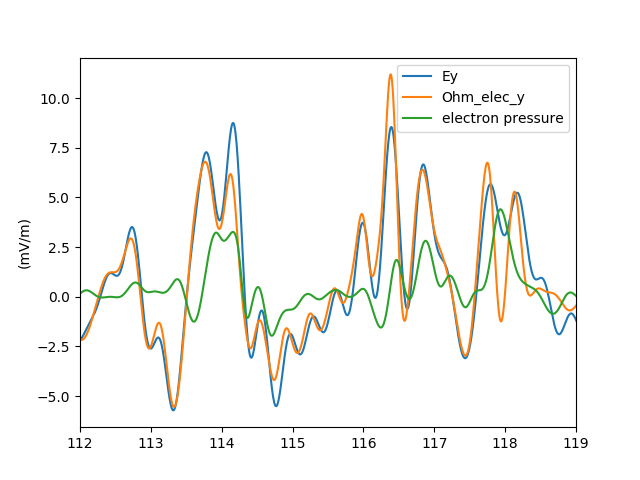

<IPython.core.display.Javascript object>


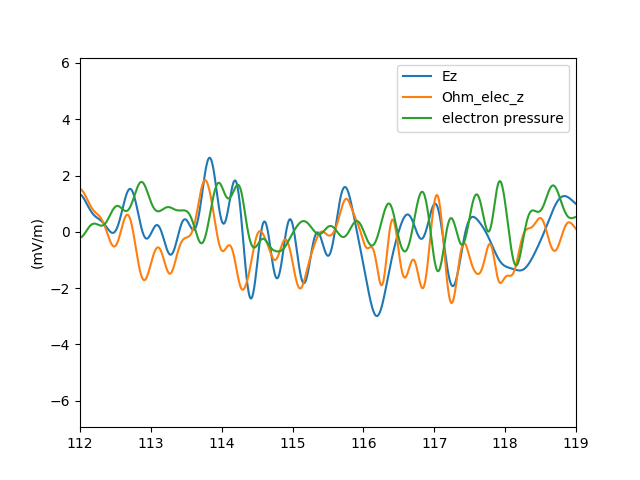

In [19]:
LHS_x = Ex *1e3
LHS_y = Ey *1e3
LHS_z = Ez *1e3

RHS_x =  (- ve_cross_B_x - divPe_x) *1e3
RHS_y =  (- ve_cross_B_y - divPe_y) *1e3
RHS_z =  (- ve_cross_B_z - divPe_z) *1e3

plt.plot(time, LHS_x, label='Ex')
plt.plot(time, RHS_x, label='Ohm_elec_x')
plt.plot(time, divPe_x*1e3, label='electron pressure')
plt.legend()
plt.xlim(time_lims)
plt.ylabel('(mV/m)')
plt.show()

plt.plot(time, LHS_y, label='Ey')
plt.plot(time, RHS_y, label='Ohm_elec_y')
plt.plot(time, divPe_y*1e3, label='electron pressure')
plt.legend()
plt.xlim(time_lims)
plt.ylabel('(mV/m)')
plt.show()

plt.plot(time, LHS_z, label='Ez')
plt.plot(time, RHS_z, label='Ohm_elec_z')
plt.plot(time, divPe_z*1e3, label='electron pressure')
plt.legend()
plt.xlim(time_lims)
plt.ylabel('(mV/m)')
plt.show()

## Biermann

### Te and ne gradients

In [20]:
Te = [Te_sat1, Te_sat2, Te_sat3, Te_sat4]
gradTe = grad(coord, Te)

Ne = [Ne_sat1, Ne_sat2, Ne_sat3, Ne_sat4]
gradNe = grad(coord, Ne)

<IPython.core.display.Javascript object>


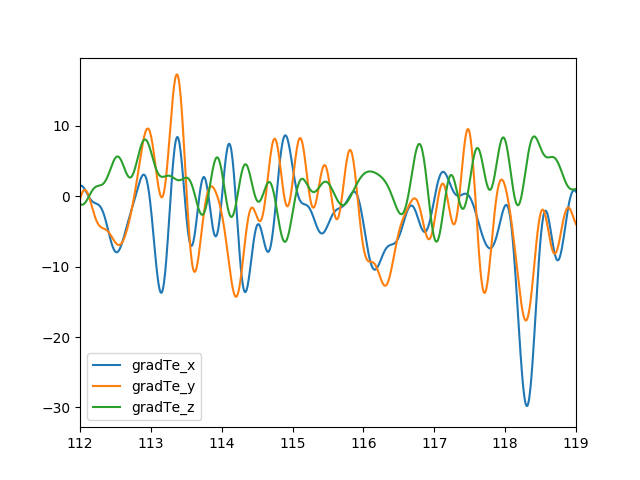

<IPython.core.display.Javascript object>


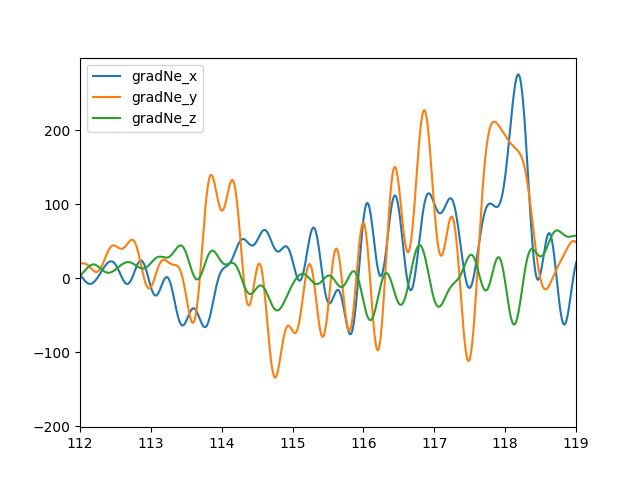

[-0.53058564 -0.54260045 -0.57269722 ...  0.29557119  0.28899312
  0.2855666 ]


In [21]:
plt.plot(time, gradTe[0], label='gradTe_x')
plt.plot(time, gradTe[1], label='gradTe_y')
plt.plot(time, gradTe[2], label='gradTe_z')
plt.legend()
plt.xlim(time_lims)
plt.show()

plt.plot(time, gradNe[0], label='gradNe_x')
plt.plot(time, gradNe[1], label='gradNe_y')
plt.plot(time, gradNe[2], label='gradNe_z')
plt.legend()
plt.xlim(time_lims)
plt.show()

print(gradTe[0])

### Biermann term:

$$  \frac{k_B}{e} \frac{\nabla n_e \times \nabla T_e}{n_e} $$

In [22]:
Ne = (Ne_sat1 + Ne_sat2 + Ne_sat3 + Ne_sat4) / 4
Biermann = vector_product(gradNe[0],gradNe[1],gradNe[2],gradTe[0],gradTe[1],gradTe[2]) / ((qe/kB)*Ne)

### "Complete Biermann":

$$ \frac{\nabla n_e \times \nabla \cdot \bar{\bar{P_e}}}{e n_e^2} $$

In [23]:
divPex = divPe_Computator(coord, Pe)[:,0]
divPey = divPe_Computator(coord, Pe)[:,1]
divPez = divPe_Computator(coord, Pe)[:,2]

complete_Biermann = vector_product(gradNe[0],gradNe[1],gradNe[2],divPex,divPey,divPez) / (qe*Ne**2)

## Induction law

### from B

$$ \frac{\partial B}{\partial t} = \nabla \times (v_e \times B) - \frac{\nabla n_e \times \nabla \cdot \bar{\bar{P_e}}}{e n_e^2}$$

/home/clement/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


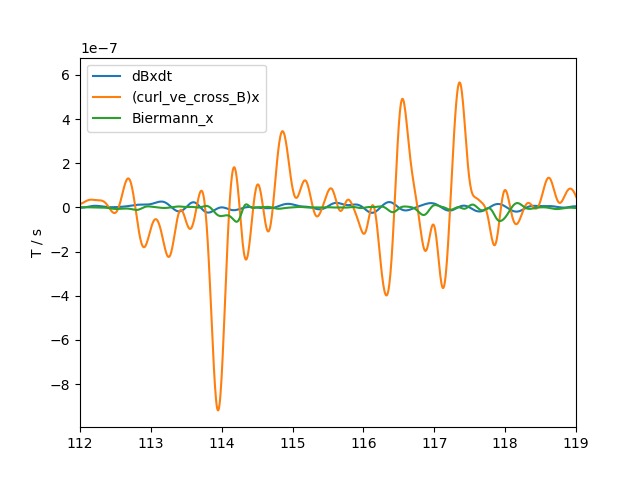

/home/clement/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


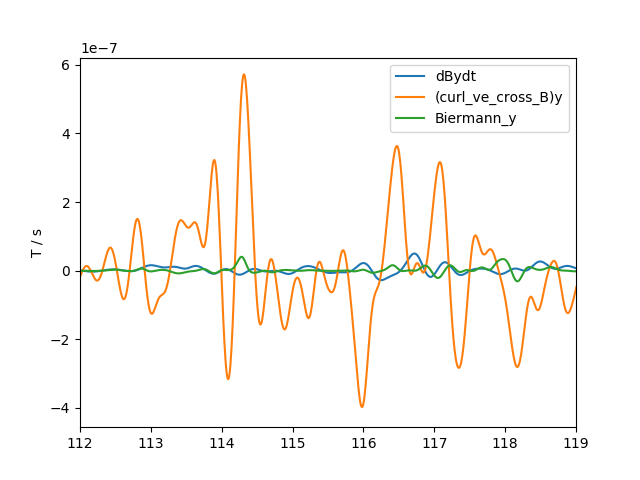

/home/clement/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


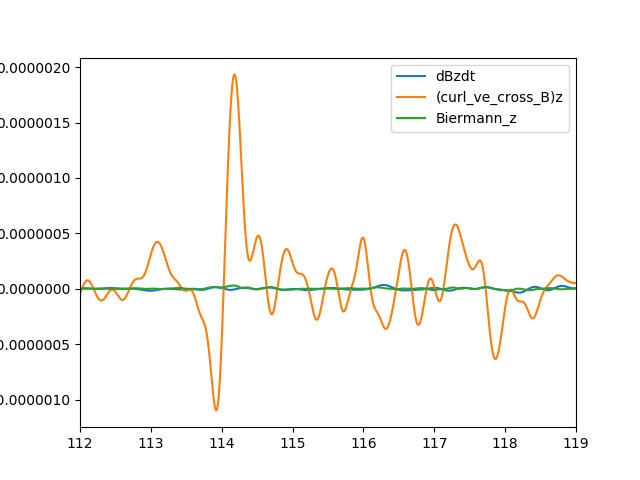

In [24]:
# qqch
ve_cross_B = [ve_cross_B_1[0], ve_cross_B_1[1], ve_cross_B_1[2],
              ve_cross_B_2[0], ve_cross_B_2[1], ve_cross_B_2[2],
              ve_cross_B_3[0], ve_cross_B_3[1], ve_cross_B_3[2],
              ve_cross_B_4[0], ve_cross_B_4[1], ve_cross_B_4[2]]

curl_ve_cross_B = curl(coord, ve_cross_B)

plt.plot(time, δBδt[0], label="dBxdt")
plt.plot(time, curl_ve_cross_B[0], label='(curl_ve_cross_B)x')
plt.plot(time, -complete_Biermann[0], label='Biermann_x')
plt.xlim(time_lims)
plt.legend()
plt.ylabel('T / s')
plt.show()

plt.plot(time, δBδt[1], label="dBydt")
plt.plot(time, curl_ve_cross_B[1], label='(curl_ve_cross_B)y')
plt.plot(time, -complete_Biermann[1], label='Biermann_y')
plt.legend()
plt.xlim(time_lims)
plt.ylabel('T / s')
plt.show()

plt.plot(time, δBδt[2], label="dBzdt")
plt.plot(time, curl_ve_cross_B[2], label='(curl_ve_cross_B)z')
plt.plot(time, -complete_Biermann[2], label='Biermann_z')
plt.xlim(time_lims)
plt.legend()
plt.ylabel('T / s')
plt.show()


### from E

$$ -\nabla \times E = \nabla \times (v_e \times B) - \frac{\nabla n_e \times \nabla \cdot \bar{\bar{P_e}}}{e n_e^2}$$

/home/clement/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


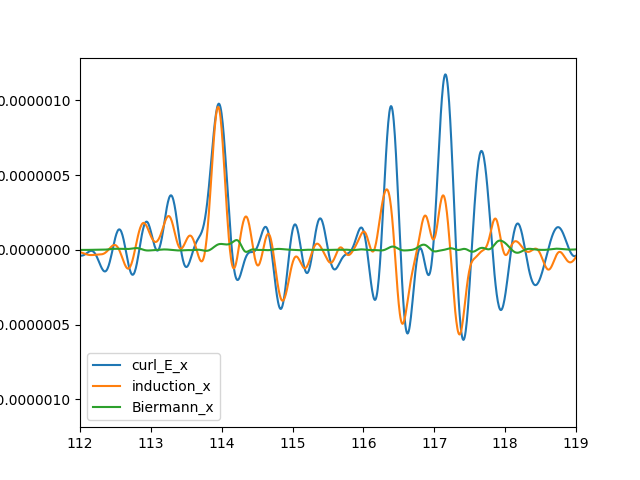

/home/clement/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


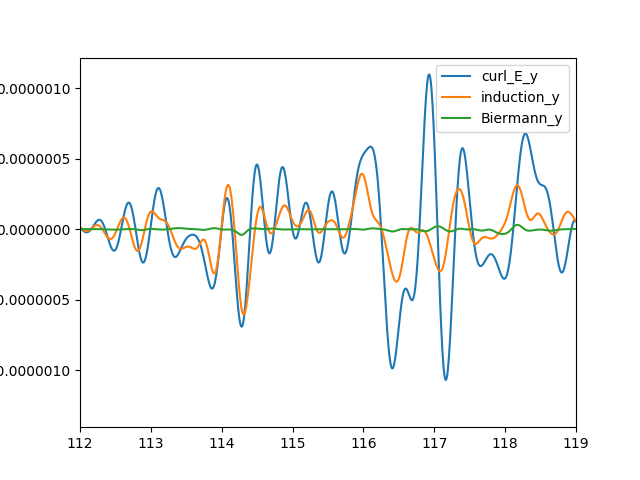

/home/clement/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


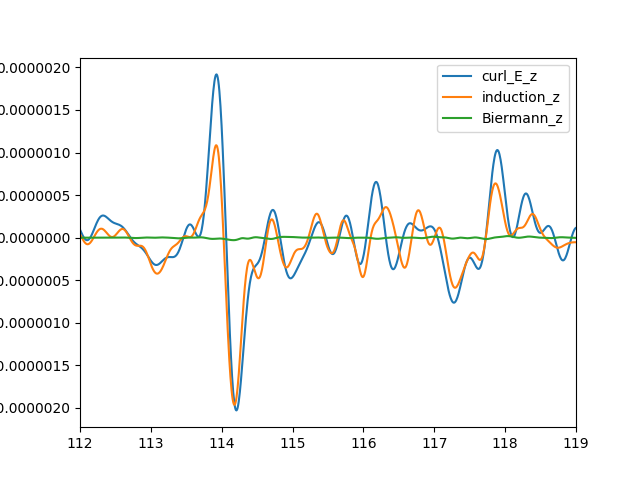

In [25]:
# Can we curl Ohm's law ?

plt.plot(time, curlE[0], label="curl_E_x")
plt.plot(time, complete_Biermann[0]-curl_ve_cross_B[0], label="induction_x")
plt.plot(time, complete_Biermann[0], label="Biermann_x")
plt.legend()
plt.xlim(time_lims)
plt.ylabel('T / s')
plt.show()

plt.plot(time, curlE[1], label="curl_E_y")
plt.plot(time, complete_Biermann[1]-curl_ve_cross_B[1], label="induction_y")
plt.plot(time, complete_Biermann[1], label="Biermann_y")
plt.legend()
plt.xlim(time_lims)
plt.ylabel('T / s')
plt.show()

plt.plot(time, curlE[2], label="curl_E_z")
plt.plot(time, complete_Biermann[2]-curl_ve_cross_B[2], label="induction_z")
plt.plot(time, complete_Biermann[2], label="Biermann_z")
plt.legend()
plt.xlim(time_lims)
plt.ylabel('T / s')
plt.show()

# Sort of, but it's not really good
# Wouldn't use it to describe anything solid in the reconnection layer

/home/clement/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


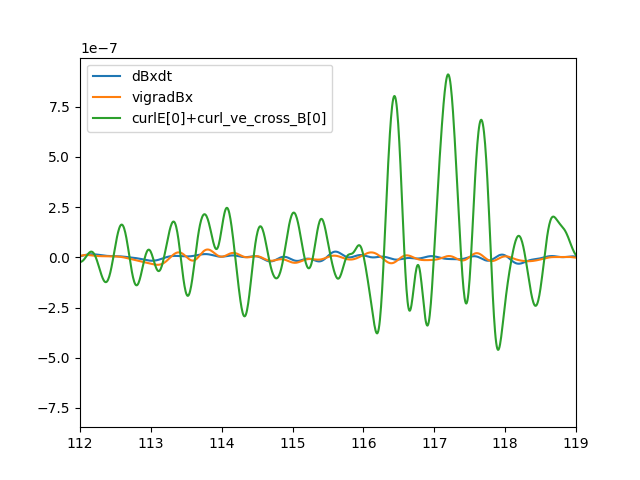

In [26]:
#plt.plot(time, δBδt[0], label="dBxdt")
plt.plot(time, dBdt[0], label="dBxdt")
plt.plot(time, vigradB[0], label="vigradBx")
plt.plot(time, curlE[0]+curl_ve_cross_B[0], label="curlE[0]+curl_ve_cross_B[0]")
plt.legend()
plt.xlim(time_lims)
plt.show()